## Algoritmo K-means do zero

K-means é um método de agrupamento que visa particionar n observações em k clusters, em que cada observação pertence ao cluster com a média mais próxima (daí o nome...).

Esse algoritmo pode ser implementado em 4 passos:
- **Passo 1** – Inicialização: Primeiro, você decide o número K de clusters que gostaria de ter. Este é um passo importante e pode depender do contexto do problema ou ser determinado por métodos auxiliares como o método do cotovelo. Em seguida, escolhem-se K pontos aleatórios dos dados como os centróides iniciais.
- **Passo 2** - Atribuição de Clusters: Cada ponto no conjunto de dados é atribuído ao cluster do centróide mais próximo. A "proximidade" é geralmente medida através da distância euclidiana, mas outras métricas de distância como Manhattan ou Minkowski também podem ser utilizadas.
- **Passo 3** - Atualização dos Centróides: Após todos os pontos serem atribuídos a um cluster, os centróides são recalculados. Isso é feito tomando a média de todos os pontos atribuídos a cada cluster; este ponto médio se torna o novo centróide desse cluster.
- **Passo 4** - Repetição: Os passos 2 e 3 são repetidos iterativamente até que os centróides parem de mudar significativamente entre as iterações, o que indica que os clusters se estabilizaram e o algoritmo convergiu.


Nesse notebook vamos explorar algumas das características básicas desse algoritmo com uma implementação passa a passa do zero.

### Definição dos métodos

Vamos criar uma série de métodos para construir nosso algoritmo de clusterização K-means.

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#### Gerar dados sintéticos

Primeiro, vamos criar uma função chamada generate_data para gerar dados sintéticos normalmente distribuidos em tornos de uma número pré-defino de pontos (centros).

Parâmetros:
- **n_samples:** Número de amostras que serão geradas para cada centro especificado.
- **n_features:** Número de características (ou dimensões) que cada amostra terá.
- **centers:** Uma lista de listas (ou array do NumPy), onde cada sublista (ou subarray) representa as coordenadas do centro de um grupo de amostras.

In [2]:
def generate_data(n_samples, n_features, centers):
    np.random.seed(42)  # para reproducibilidade
    data = []
    for center in centers:
        data.append(np.random.randn(n_samples, n_features) + np.array(center))
    return np.vstack(data)

#### Inicializar os centróides

A função initialize_centroids é utilizada para inicializar os centróides do nosso algoritmo de clusterização K-means. O propósito desta função é selecionar k centróides aleatórios de um conjunto de dados X dado (gerado pelo função generate_data). :

Parâmetros:
- **X:** Um array do NumPy representando o conjunto de dados, onde cada linha é uma amostra e cada coluna uma característica.
- **k:** Número de centróides a serem inicializados, ou seja, o número de clusters desejados.

In [3]:
def initialize_centroids(X, k):
    np.random.seed(42)
    indices = np.random.choice(X.shape[0], size=k, replace=False)
    return X[indices]

#### Atribuir os clusters

A função assign_clusters é projetada para atribuir cada amostra em um conjunto de dados X a um cluster com base na proximidade com os centróides desses clusters. 

Parâmetros:
- **X:** Um array do NumPy representando o conjunto de dados, onde cada linha é uma amostra e cada coluna uma característica.
- **centroids:** Um array do NumPy contendo os centróides atuais dos clusters, onde cada linha é um centróide.

In [4]:
def assign_clusters(X, centroids):
    # Atribui cada ponto de dados ao centróide mais próximo
    distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)
     


#### Atualizar os centróiodes

A função update_centroids é usada para recalcular as posições dos centróides, com base nas atuais atribuições de cada ponto de dado a um cluster específico, assinalada anteriormente pela função assign_clusters. Esta função atualiza os centróides para que eles se tornem o ponto médio (centro geométrico) dos pontos de dados atribuídos a cada cluster.

Parâmetros:
- **X:** Um array do NumPy contendo o conjunto de dados, onde cada linha é uma amostra e cada coluna uma característica.
- **clusters:** Um array do NumPy de mesma dimensão que o número de linhas de X, contendo o índice do cluster ao qual cada amostra foi atribuída.
- **k:** O número total de clusters.

In [5]:
def update_centroids(X, clusters, k):
    new_centroids = []
    for i in range(k):
        new_centroids.append(X[clusters == i].mean(axis=0))
    return np.array(new_centroids)


### Algoritmo de K-means
A função kmeans implementa o algoritmo de K-means, que particiona um conjunto de dados X em 
k clusters distintos. O algoritmo é construído usando as funções definidas anteriormente para atribuir pontos a clusters e atualizar os centróides desses clusters. Inclui também a opção de retornar o histórico de todos os centróides e atribuições de cluster ao longo das iterações.

Parâmetros:
- **X:** Um array do NumPy contendo o conjunto de dados, onde cada linha é uma amostra e cada coluna uma característica.
- **k:** O número total de clusters desejados.
- **max_iters:** O número máximo de iterações para executar o algoritmo (default é 100).
- **return_history:** Um booleano que, se verdadeiro, faz a função retornar o histórico completo das atribuições de clusters e centróides ao longo das iterações.

In [6]:
def kmeans(X, k, max_iters=100, return_history=False):
    centroids = initialize_centroids(X, k)
    history_centroids = [centroids]
    clusters = assign_clusters(X, centroids)
    history_clusters = [clusters]
    history_wcss = []
    history = {}
    
    # Convergiu?
    converged = False
    # Critério de convergência: 
    # distância entre os atuais e antigos centroides  
    stop_crit = 10e-5
    while not converged:
        for i in range(max_iters):            
            old_centroids = centroids
            clusters = assign_clusters(X, centroids)
            centroids = update_centroids(X, clusters, k)
            history_centroids.append(centroids)
            history_clusters.append(clusters)
            
            # Checa critério de parada
            centroid_change = np.mean(np.linalg.norm(old_centroids - centroids, axis=1))
            if centroid_change < stop_crit:
                converged = True
                break
        
    if return_history:
        history['history_clusters'] = history_clusters
        history['history_centroids'] = history_centroids
        return clusters, centroids, history
    else:
        return clusters, centroids


#### Visualização da otimização

A função plot_step é usada para visualizar os passos do K-means, mostrando a posição dos pontos de dados e dos centróides a cada iteração do algoritmo.

Parâmetros:
- **frame:** O número da iteração (ou "frame" da animação) que está sendo visualizado.
- **X:** Um array do NumPy contendo o conjunto de dados.
- **history_clusters:** Uma lista de arrays, onde cada array contém os índices do cluster de cada ponto em X para cada iteração.
- **history_centroids:** Uma lista de arrays, onde cada array contém as coordenadas dos centróides em cada iteração.
- **ax:** Um objeto de eixo do Matplotlib sobre o qual o gráfico será desenhado.

In [7]:
def plot_step(frame, X, history_clusters, history_centroids, ax):
    ax.cla()  # Limpa o eixo para o novo frame
    clusters = history_clusters[frame]
    centroids = history_centroids[frame]
    ax.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', label='Pontos de dados')
    ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.5, marker='x',  linewidths=5, label='Centróides')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title('Agrupamento com K-Means - interação {}'.format(frame + 1))
    ax.legend()



A função create_kmeans_animation serve para visualizar o processo de clusterização pelo método K-means, mostrando como os centróides e os agrupamentos mudam ao longo das iterações. 

Parâmetros:
- **X:** Um array do NumPy contendo o conjunto de dados, onde cada linha é uma amostra e cada coluna uma característica.
- **history_clusters:** Uma lista de arrays, onde cada array contém os índices de cluster de cada ponto em X para cada iteração.
- **history_centroids:** Uma lista de arrays, onde cada array contém as coordenadas dos centróides em cada iteração.
- **output_dir:** Um string que indica o diretório onde as animações serão salvas (o padrão é o diretório 'output').

In [8]:
def create_kmeans_animation(X, history_clusters, history_centroids, output_dir='output'):
    # Configurando a figura
    fig, ax = plt.subplots(figsize=(6, 4))

    # Criando a animação
    ani = FuncAnimation(fig, plot_step, frames=len(history_centroids),
                        fargs=(X, history_clusters, history_centroids, ax),
                        interval=600, repeat=False)

    # Criar diretório se não existir
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Salvar a animação
    mp4_path = os.path.join(output_dir, 'kmeans_clustering.mp4')
    gif_path = os.path.join(output_dir, 'kmeans_clustering.gif')
    ani.save(mp4_path, writer='ffmpeg', fps=1)
    ani.save(gif_path, writer='pillow', fps=1)

    # Para mostrar a animação no Jupyter Notebook ou salvar em arquivo
    plt.close(fig)  # Fechar a figura impede que um frame estático adicional seja exibido no notebook

    # Exibe a animação como HTML no Jupyter Notebook
    return HTML(ani.to_jshtml())

### Aplicação 

Vamos gerar dados aleatórios 2D para três clusters.

- Cluster 1: centrado em (2, 2)
- Cluster 2: centrado em (8, 8)
- Cluster 3: centrado em (5, 1)

Cada cluster terá 100 pontos, resultando em uma matriz final de dimensões (300, 2).

In [9]:
# Gerando dados
centers = [[2, 2], [3,6], [4, 0]]
X = generate_data(200, 2, centers)
print(np.shape(X))
X[:10]


(600, 2)


array([[2.49671415, 1.8617357 ],
       [2.64768854, 3.52302986],
       [1.76584663, 1.76586304],
       [3.57921282, 2.76743473],
       [1.53052561, 2.54256004],
       [1.53658231, 1.53427025],
       [2.24196227, 0.08671976],
       [0.27508217, 1.43771247],
       [0.98716888, 2.31424733],
       [1.09197592, 0.5876963 ]])

Visualizar os dados.

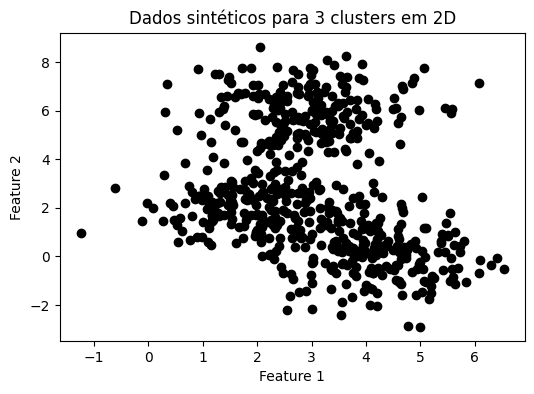

In [10]:
# Plotando os dados
plt.figure(figsize=(6, 4))

plt.scatter(X[:, 0], X[:, 1], color='k', edgecolor='k')

plt.title('Dados sintéticos para 3 clusters em 2D')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(False)
plt.show()

Executar o K-Means

In [11]:
clusters, centroids, history = kmeans(X, k=3, return_history=True)

history_clusters = history['history_clusters'] 
history_centroids = history['history_centroids'] 


Visualizar resultado final.

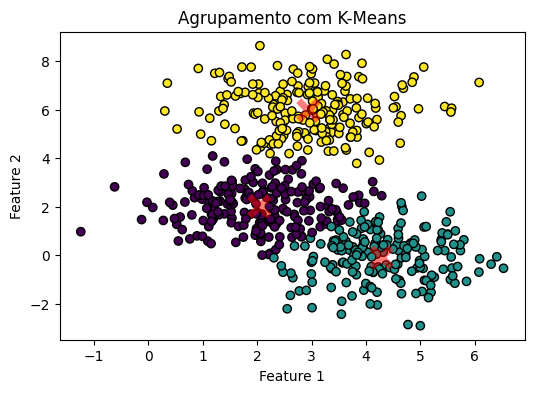

In [12]:
# Plotando o resultado
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.5, marker='x',  linewidths=5)
plt.title('Agrupamento com K-Means')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Vizualizar as interações.

In [13]:
create_kmeans_animation(X, history_clusters, history_centroids)